In [60]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [74]:
components = np.loadtxt('../dependencies.txt', delimiter=",");

In [75]:
components.shape

(10440, 3)

In [76]:
np.sum(np.where(components[:, 2] > 0.1, 1, 0))

646

In [77]:
def draw_by_prob(prob):
    G = nx.Graph()
    nodes_with_edges = set()
    for (u, v, w) in components:
        if w > prob:
            G.add_edge(int(u), int(v), weight=w)
            nodes_with_edges.add(int(u))
            nodes_with_edges.add(int(v))
        if not u in G.nodes:
            G.add_node(int(u))
    all_weights = []
    for (node1,node2,data) in G.edges(data=True):
            all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))  
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=20)
    for weight in unique_weights:
        weighted_edges = [(u, v) for (u, v, w) in G.edges(data=True) if w['weight'] == weight]
        width = weight
        nx.draw_networkx_edges(G, pos, edgelist=weighted_edges, width=width)
    print(list(nodes_with_edges))
    print(len(nodes_with_edges))

[1, 5, 8, 11, 12, 15, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 33, 34, 35, 37, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 94, 98, 99, 100, 101, 102, 103, 105, 107, 108, 109, 116, 117, 118, 119, 120, 121, 122, 123, 124, 128, 129, 131, 132, 133, 139, 141, 142, 143]
90


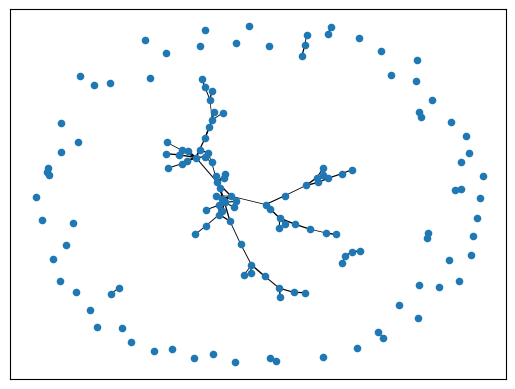

In [83]:
draw_by_prob(0.5)

In [90]:
import pandas as pd
df = pd.read_csv('../experiments.csv')

In [95]:
df['runtime']
df['solver name']

0         CG+GR+GC+T+BP with AStarand Decomp
1         CG+GR+GC+T+BP with AStarand Decomp
2         CG+GR+DC+T+BP with AStarand Decomp
3         CG+GR+GC+T+BP with AStarand Decomp
4         CG+GR+GC+T+BP with AStarand Decomp
                        ...                 
32535     CG+GR+GC+T+BP with AStarand Decomp
32536    WDG+GR+DC+T+BP with AStarand Decomp
32537    WDG+GR+DC+T+BP with AStarand Decomp
32538     CG+GR+DC+T+BP with AStarand Decomp
32539    WDG+GR+DC+T+BP with AStarand Decomp
Name: solver name, Length: 32540, dtype: object

In [108]:
list(df.head(1))

['runtime',
 '#high-level expanded',
 '#high-level generated',
 '#low-level expanded',
 '#low-level generated',
 'solution cost',
 'min f value',
 'root g value',
 'root f value',
 '#adopt bypasses',
 'standard conflicts',
 'rectangle conflicts',
 'corridor conflicts',
 'target conflicts',
 'mutex conflicts',
 '#merge MDDs',
 '#solve 2 agents',
 '#memoization',
 'runtime of building heuristic graph',
 'runtime of solving MVC',
 'runtime of detecting conflicts',
 'runtime of rectangle conflicts',
 'runtime of corridor conflicts',
 'runtime of mutex conflicts',
 'runtime of building MDDs',
 'runtime of building constraint tables',
 'runtime of building CATs',
 'runtime of path finding',
 'runtime of generating child nodes',
 'preprocessing runtime',
 'solver name',
 'instance name']

In [102]:
decomp = df[df['solver name'].str.contains('Decomp')]
standard = df[df['solver name'].str.contains('Decomp')==False]

In [101]:
len(decomp)

27123

In [103]:
len(standard)

5417

In [104]:
set(df['instance name'].str + df['k'])

{'scens/Berlin_1_256-even-1.scen:',
 'scens/Berlin_1_256-even-10.scen:',
 'scens/Berlin_1_256-even-11.scen:',
 'scens/Berlin_1_256-even-12.scen:',
 'scens/Berlin_1_256-even-13.scen:',
 'scens/Berlin_1_256-even-14.scen:',
 'scens/Berlin_1_256-even-15.scen:',
 'scens/Berlin_1_256-even-16.scen:',
 'scens/Berlin_1_256-even-17.scen:',
 'scens/Berlin_1_256-even-18.scen:',
 'scens/Berlin_1_256-even-19.scen:',
 'scens/Berlin_1_256-even-2.scen:',
 'scens/Berlin_1_256-even-20.scen:',
 'scens/Berlin_1_256-even-21.scen:',
 'scens/Berlin_1_256-even-22.scen:',
 'scens/Berlin_1_256-even-23.scen:',
 'scens/Berlin_1_256-even-24.scen:',
 'scens/Berlin_1_256-even-25.scen:',
 'scens/Berlin_1_256-even-3.scen:',
 'scens/Berlin_1_256-even-4.scen:',
 'scens/Berlin_1_256-even-5.scen:',
 'scens/Berlin_1_256-even-6.scen:',
 'scens/Berlin_1_256-even-7.scen:',
 'scens/Berlin_1_256-even-8.scen:',
 'scens/Berlin_1_256-even-9.scen:',
 'scens/Boston_0_256-even-1.scen:',
 'scens/Boston_0_256-even-10.scen:',
 'scens/Bos